## Setup and Imports

Import necessary libraries for data analysis and visualization.

In [1]:
import os
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.dpi'] = 110
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Helvetica', 'sans-serif']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

# Random seed for reproducibility
np.random.seed(42)
rng = np.random.default_rng(seed=42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Dataset Configuration

Define paths to the fish dataset and verify structure.

In [2]:
# Define project root and data paths
project_root = Path(r"D:\Projects\Practical_Deep_hw1")
data_root = project_root / "Data" / "2" / "Fish_Dataset" / "Fish_Dataset"

# Ensure plots directory exists
plots_dir = project_root / "plots"
plots_dir.mkdir(parents=True, exist_ok=True)

# Fish species in the dataset
fish_species = [
    "Black Sea Sprat",
    "Gilt-Head Bream",
    "Hourse Mackerel",  # Note: typo in original dataset
    "Red Mullet",
    "Red Sea Bream",
    "Sea Bass",
    "Shrimp",
    "Striped Red Mullet",
    "Trout"
]

print(f"Project root: {project_root}")
print(f"Data root: {data_root}")
print(f"\nFish species in dataset: {len(fish_species)}")
for i, species in enumerate(fish_species, 1):
    print(f"  {i}. {species}")

Project root: D:\Projects\Practical_Deep_hw1
Data root: D:\Projects\Practical_Deep_hw1\Data\2\Fish_Dataset\Fish_Dataset

Fish species in dataset: 9
  1. Black Sea Sprat
  2. Gilt-Head Bream
  3. Hourse Mackerel
  4. Red Mullet
  5. Red Sea Bream
  6. Sea Bass
  7. Shrimp
  8. Striped Red Mullet
  9. Trout


---

# Question 1: Dataset Size and Overview

## Basic Statistics

In [3]:
# Count images per species
species_counts = {}
total_images = 0

for species in fish_species:
    species_path = data_root / species / species
    if species_path.exists():
        images = list(species_path.glob("*.png"))
        count = len(images)
        species_counts[species] = count
        total_images += count
    else:
        species_counts[species] = 0
        print(f"Warning: Path not found for {species}")

print("=" * 60)
print("DATASET SIZE OVERVIEW")
print("=" * 60)
print(f"\nTotal images in dataset: {total_images:,}")
print(f"Number of species (classes): {len(fish_species)}")
print(f"Average images per species: {total_images / len(fish_species):.0f}")
print("\n" + "=" * 60)
print("Images per species:")
print("=" * 60)
for species, count in species_counts.items():
    print(f"  {species:25s}: {count:4d} images")
print("=" * 60)

DATASET SIZE OVERVIEW

Total images in dataset: 9,000
Number of species (classes): 9
Average images per species: 1000

Images per species:
  Black Sea Sprat          : 1000 images
  Gilt-Head Bream          : 1000 images
  Hourse Mackerel          : 1000 images
  Red Mullet               : 1000 images
  Red Sea Bream            : 1000 images
  Sea Bass                 : 1000 images
  Shrimp                   : 1000 images
  Striped Red Mullet       : 1000 images
  Trout                    : 1000 images


---

# Question 2: Sample Contents and Dimensions

## Image Dimensions Analysis

In [4]:
# Sample images from dataset to analyze dimensions
print("Analyzing image dimensions (sampling 100 images per species)...\n")

sizes_counter = Counter()
mode_counter = Counter()
aspect_ratios = []

for species in fish_species:
    species_path = data_root / species / species
    if not species_path.exists():
        continue
    
    images = list(species_path.glob("*.png"))
    sample_size = min(100, len(images))
    sampled = rng.choice(images, size=sample_size, replace=False)
    
    for img_path in sampled:
        try:
            with Image.open(img_path) as img:
                sizes_counter[img.size] += 1
                mode_counter[img.mode] += 1
                aspect_ratios.append(img.size[0] / img.size[1])
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

print("=" * 60)
print("IMAGE DIMENSIONS ANALYSIS")
print("=" * 60)
print("\nMost common image sizes (width x height):")
for (w, h), count in sizes_counter.most_common(10):
    print(f"  {w:4d} x {h:4d}  ->  {count:4d} images")

print("\n" + "=" * 60)
print("Color mode (channels):")
print("=" * 60)
for mode, count in mode_counter.most_common():
    channels = {"RGB": "3 channels", "RGBA": "4 channels", "L": "1 channel (grayscale)"}
    print(f"  {mode:8s} ({channels.get(mode, 'unknown')})  ->  {count:4d} images")

aspect_ratios = np.array(aspect_ratios)
print("\n" + "=" * 60)
print(f"Aspect ratio (width/height):")
print("=" * 60)
print(f"  Mean:   {aspect_ratios.mean():.3f}")
print(f"  Median: {np.median(aspect_ratios):.3f}")
print(f"  Std:    {aspect_ratios.std():.3f}")
print("=" * 60)

Analyzing image dimensions (sampling 100 images per species)...

IMAGE DIMENSIONS ANALYSIS

Most common image sizes (width x height):
   590 x  445  ->   900 images

Color mode (channels):
  RGB      (3 channels)  ->   900 images

Aspect ratio (width/height):
  Mean:   1.326
  Median: 1.326
  Std:    0.000


## Preprocessing Recommendations

Based on the dataset characteristics:

In [5]:
print("\n" + "=" * 60)
print("PREPROCESSING RECOMMENDATIONS")
print("=" * 60)
print("""
1. COLOR NORMALIZATION:
   - Convert all images to RGB (3 channels)
   - Handle any RGBA images by dropping alpha channel
   
2. SPATIAL RESIZING:
   - Resize to uniform size: 224×224 or 256×256
   - Use aspect-ratio preserving resize + center crop
   - Or use padding to maintain aspect ratio
   
3. NORMALIZATION:
   - Use ImageNet mean/std for transfer learning:
     mean = [0.485, 0.456, 0.406]
     std = [0.229, 0.224, 0.225]
   - Or compute dataset-specific statistics
   
4. DATA AUGMENTATION (training only):
   - Horizontal flipping (fish can face either direction)
   - Random rotation (±15°)
   - Color jitter (brightness, contrast, saturation)
   - Random zoom/crop
   - Random Gaussian blur
   - Vertical flipping is NOT valid (fish don't swim upside down)
""")
print("=" * 60)


PREPROCESSING RECOMMENDATIONS

1. COLOR NORMALIZATION:
   - Convert all images to RGB (3 channels)
   - Handle any RGBA images by dropping alpha channel
   
2. SPATIAL RESIZING:
   - Resize to uniform size: 224×224 or 256×256
   - Use aspect-ratio preserving resize + center crop
   - Or use padding to maintain aspect ratio
   
3. NORMALIZATION:
   - Use ImageNet mean/std for transfer learning:
     mean = [0.485, 0.456, 0.406]
     std = [0.229, 0.224, 0.225]
   - Or compute dataset-specific statistics
   
4. DATA AUGMENTATION (training only):
   - Horizontal flipping (fish can face either direction)
   - Random rotation (±15°)
   - Color jitter (brightness, contrast, saturation)
   - Random zoom/crop
   - Random Gaussian blur
   - Vertical flipping is NOT valid (fish don't swim upside down)



---

# Question 3: Class Balance Analysis

## Distribution of Samples per Class

In [6]:
# Create DataFrame for better visualization
df_species = pd.DataFrame([
    {"Species": species, "Count": count}
    for species, count in species_counts.items()
]).sort_values("Count", ascending=False)

print("\n=" * 60)
print("CLASS BALANCE STATISTICS")
print("=" * 60)
print(f"\nMinimum images per species: {df_species['Count'].min()}")
print(f"Maximum images per species: {df_species['Count'].max()}")
print(f"Mean images per species:    {df_species['Count'].mean():.1f}")
print(f"Median images per species:  {df_species['Count'].median():.1f}")
print(f"Std deviation:              {df_species['Count'].std():.1f}")
print("\n" + "=" * 60)

# Check if balanced
is_balanced = df_species['Count'].std() < df_species['Count'].mean() * 0.1
print(f"\n{'Dataset is BALANCED' if is_balanced else 'Dataset shows CLASS IMBALANCE'}")
print("=" * 60)


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
CLASS BALANCE STATISTICS

Minimum images per species: 1000
Maximum images per species: 1000
Mean images per species:    1000.0
Median images per species:  1000.0
Std deviation:              0.0


Dataset is BALANCED


## Visualization: Class Distribution

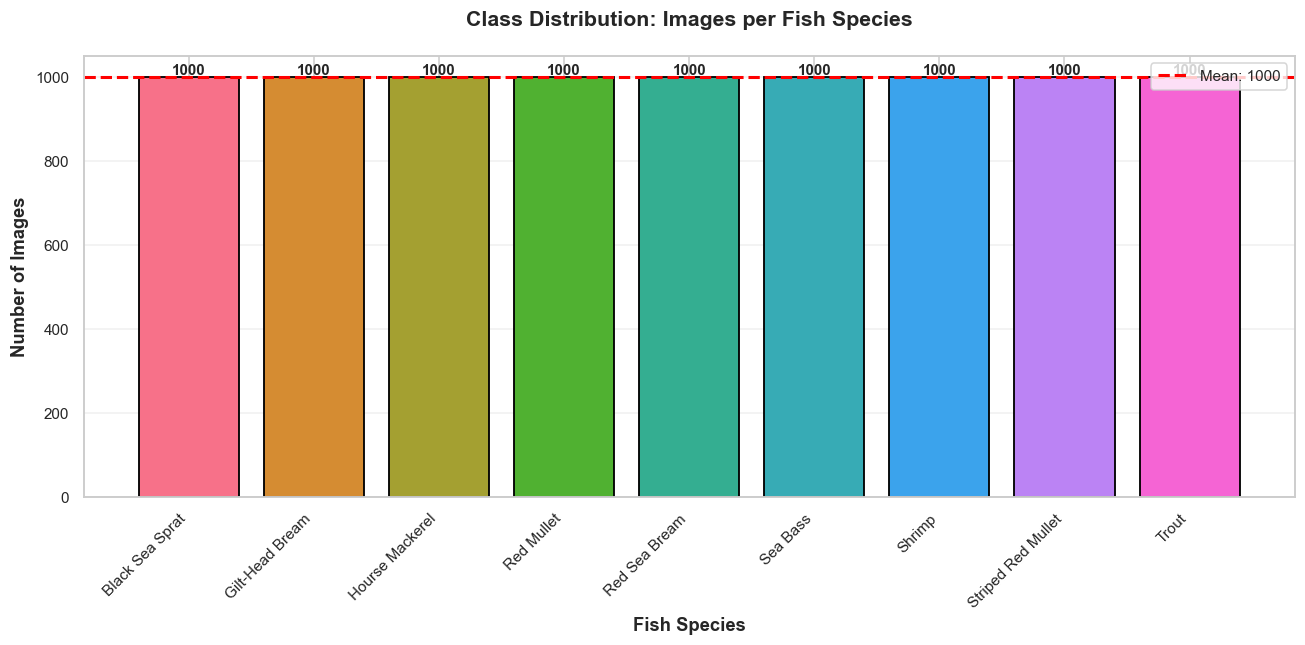

Saved: D:\Projects\Practical_Deep_hw1\plots\class_distribution.png


In [7]:
# Create bar plot
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(range(len(df_species)), df_species['Count'], 
               color=sns.color_palette("husl", len(df_species)),
               edgecolor='black', linewidth=1.2)

ax.set_xlabel('Fish Species', fontweight='bold')
ax.set_ylabel('Number of Images', fontweight='bold')
ax.set_title('Class Distribution: Images per Fish Species', 
             fontweight='bold', pad=20)

ax.set_xticks(range(len(df_species)))
ax.set_xticklabels(df_species['Species'], rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add mean line
mean_count = df_species['Count'].mean()
ax.axhline(y=mean_count, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_count:.0f}')
ax.legend(loc='upper right', fontsize=10)

ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(plots_dir / 'class_distribution.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"Saved: {plots_dir / 'class_distribution.png'}")

---

# Question 4: Benchmark Results & Related Work

## Literature Review

### Dataset Publication

**Original Paper:**
> O. Ulucan, D. Karakaya, and M. Turkan. "A Large-Scale Dataset for Fish Segmentation and Classification." *2020 Innovations in Intelligent Systems and Applications Conference (ASYU)*, IEEE, 2020.

### Benchmark Methods from Literature

The original paper compared:

1. **Semantic Segmentation Methods:**
   - U-Net
   - SegNet
   - FCN (Fully Convolutional Networks)

2. **Feature Extraction + Classification:**
   - Bag of Features (BoF)
   - Traditional handcrafted features

3. **Deep Learning Classification:**
   - Convolutional Neural Networks (CNNs)
   - Transfer Learning with pretrained models

### Expected Performance Range

Based on similar fine-grained classification tasks:

- **Simple CNN from scratch:** 70-85% accuracy
- **Transfer Learning (ResNet, VGG):** 90-95% accuracy
- **Advanced methods (EfficientNet, ViT):** 95-98% accuracy

### Key Challenges

1. **Intra-class variability:** Different lighting, angles, sizes
2. **Inter-class similarity:** Some fish species look very similar (e.g., Red Mullet vs Striped Red Mullet)
3. **Background complexity:** Varying backgrounds in supermarket setting
4. **Scale variation:** Fish appear at different distances from camera

---

# Question 5: Sample Visualization

## Random Samples from Each Species

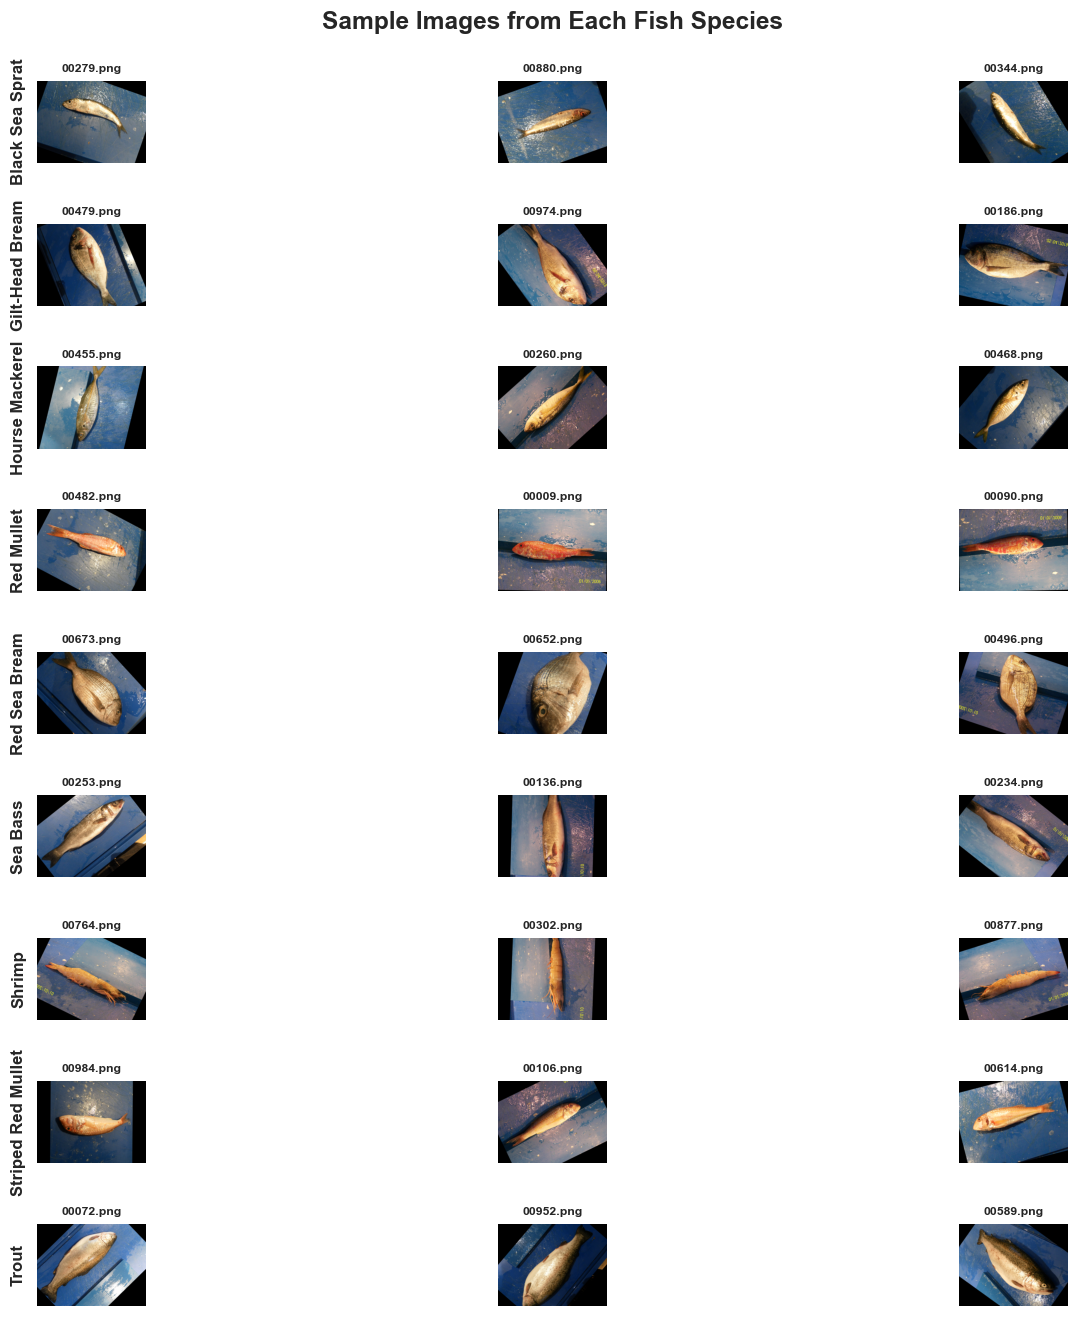


Saved: D:\Projects\Practical_Deep_hw1\plots\fish_samples_grid.png


In [8]:
def plot_fish_samples(fish_species, data_root, num_samples=3, figsize=(15, 12)):
    """
    Plot random samples from each fish species in a grid.
    
    Args:
        fish_species: List of species names
        data_root: Path to dataset root
        num_samples: Number of samples per species
        figsize: Figure size tuple
    """
    n_species = len(fish_species)
    
    fig, axes = plt.subplots(n_species, num_samples, figsize=figsize)
    fig.suptitle('Sample Images from Each Fish Species', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    for row_idx, species in enumerate(fish_species):
        species_path = data_root / species / species
        
        if not species_path.exists():
            print(f"Warning: Path not found: {species_path}")
            continue
        
        # Get random samples
        all_images = list(species_path.glob("*.png"))
        if len(all_images) < num_samples:
            print(f"Warning: Not enough images for {species}")
            continue
        
        sampled = rng.choice(all_images, size=num_samples, replace=False)
        
        for col_idx, img_path in enumerate(sampled):
            ax = axes[row_idx, col_idx]
            ax.axis('off')
            
            try:
                with Image.open(img_path) as img:
                    img_rgb = img.convert('RGB')
                    ax.imshow(img_rgb)
                
                # Add species label on first column
                if col_idx == 0:
                    ax.text(-0.1, 0.5, species, 
                           transform=ax.transAxes,
                           fontsize=11, fontweight='bold',
                           rotation=90, va='center', ha='right',
                           family='sans-serif')
                
                # Add image filename as title
                ax.set_title(img_path.name, fontsize=8)
                
            except Exception as e:
                ax.text(0.5, 0.5, f'Error\nloading\nimage', 
                       ha='center', va='center', fontsize=8)
                print(f"Error loading {img_path}: {e}")
    
    plt.tight_layout()
    save_path = plots_dir / 'fish_samples_grid.png'
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"\nSaved: {save_path}")

# Generate the grid
plot_fish_samples(fish_species, data_root, num_samples=3)

## Comparison: Similar vs. Distinct Species

Let's compare visually similar species that might be harder to classify.


SIMILAR SPECIES COMPARISON

These species might be harder to distinguish:

Mullet Species Comparison: Red Mullet vs Striped Red Mullet


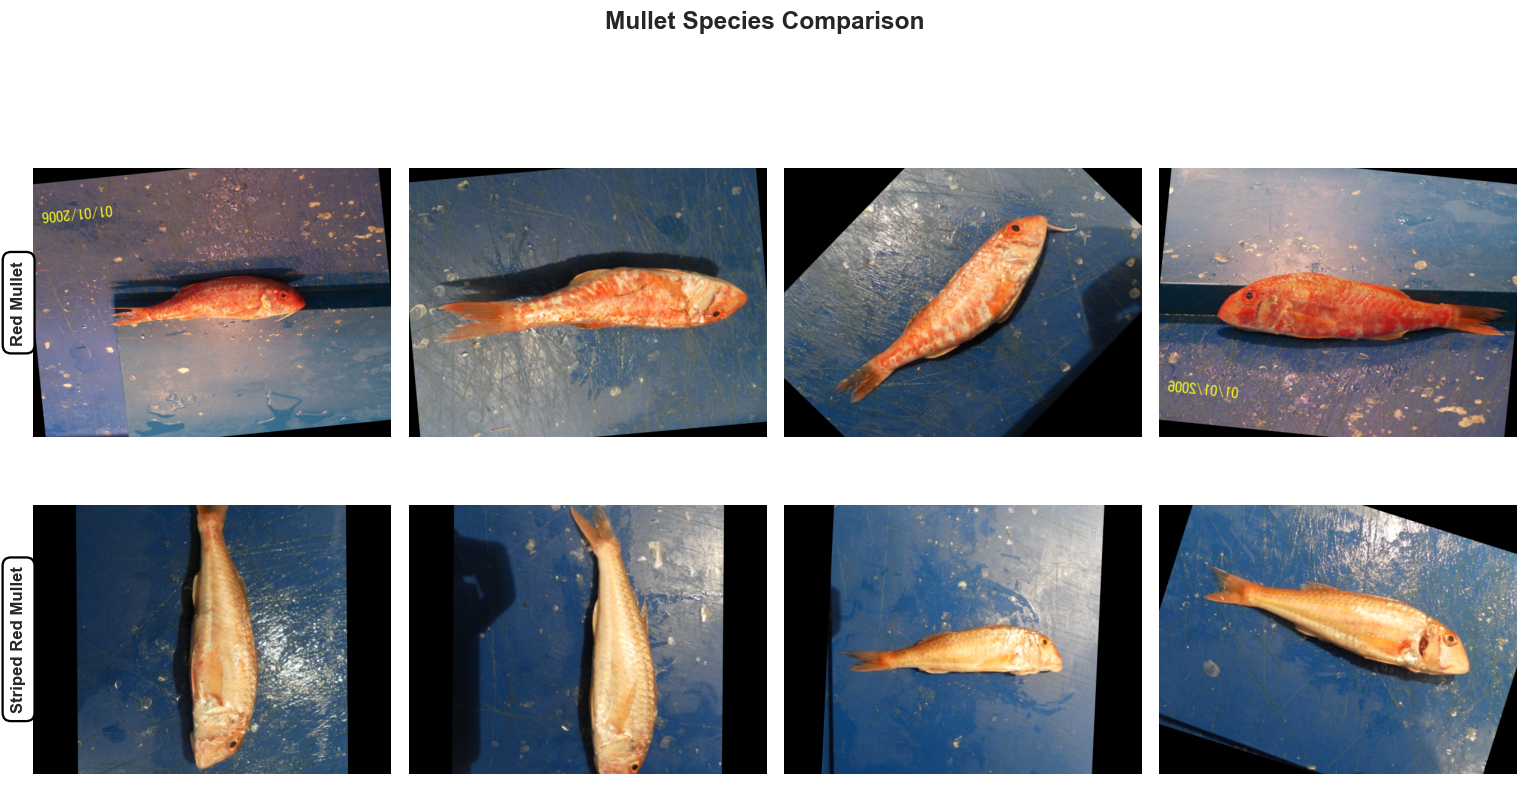

Saved: D:\Projects\Practical_Deep_hw1\plots\mullet_species_comparison.png

Bream Species Comparison: Gilt-Head Bream vs Red Sea Bream


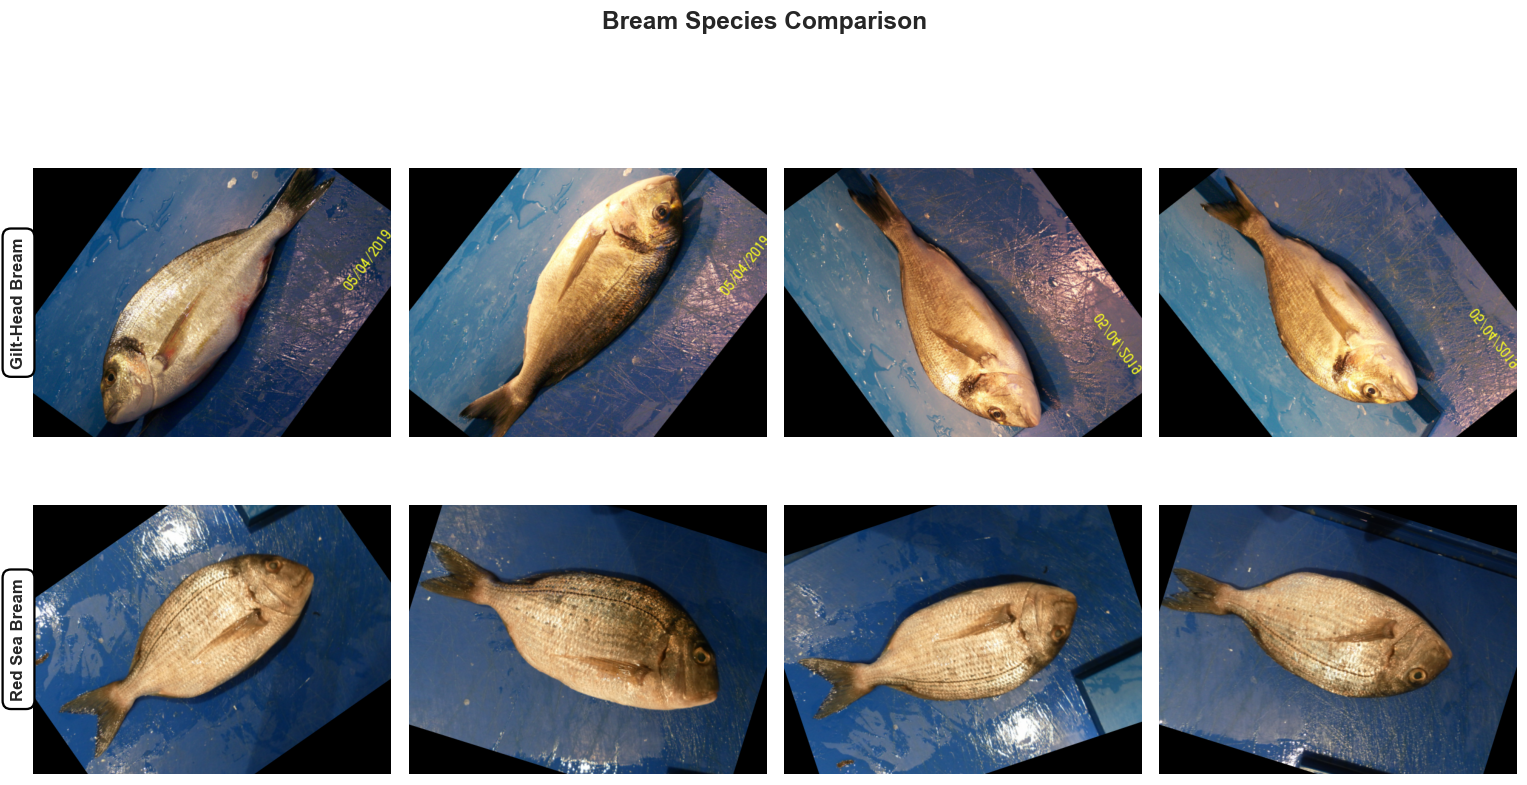

Saved: D:\Projects\Practical_Deep_hw1\plots\bream_species_comparison.png


EASILY DISTINGUISHABLE SPECIES

These species are visually very distinct:

Comparing: Black Sea Sprat, Shrimp, Trout, Sea Bass


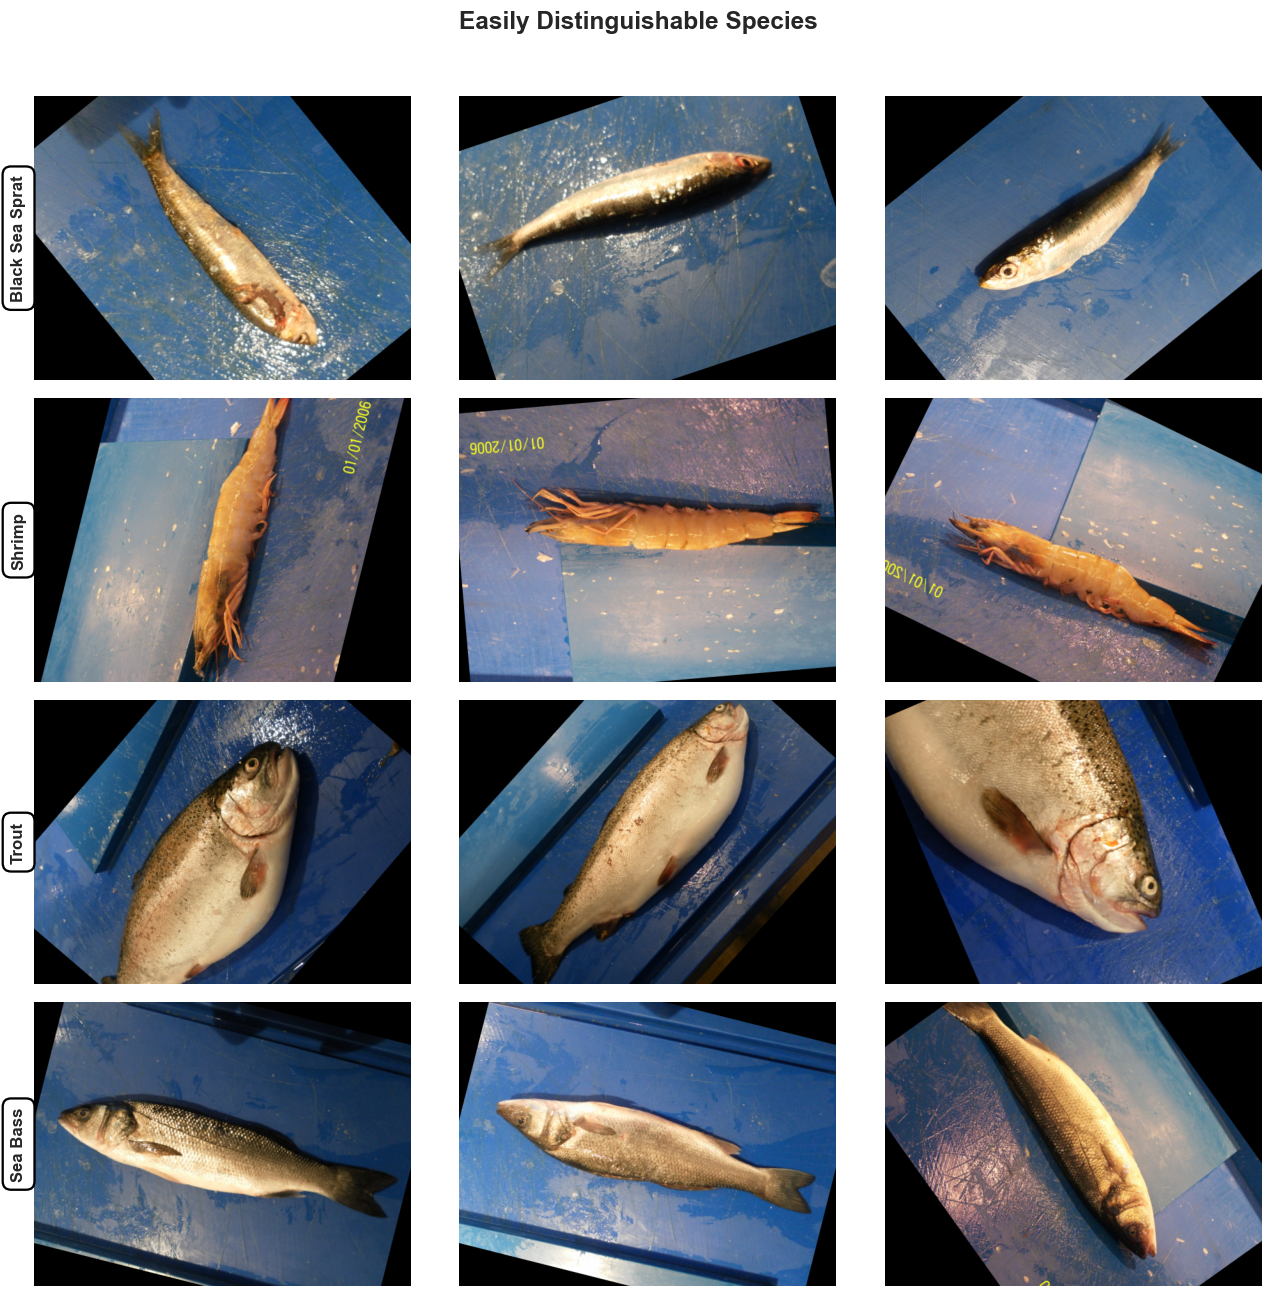

Saved: D:\Projects\Practical_Deep_hw1\plots\distinct_species_comparison.png


In [9]:
def plot_species_comparison(species_list, data_root, num_samples=4, figsize=(14, 8)):
    """
    Compare similar species side by side.
    """
    n_species = len(species_list)
    
    fig, axes = plt.subplots(n_species, num_samples, figsize=figsize)
    if n_species == 1:
        axes = axes.reshape(1, -1)
    
    for row_idx, species in enumerate(species_list):
        species_path = data_root / species / species
        
        if not species_path.exists():
            continue
        
        all_images = list(species_path.glob("*.png"))
        sampled = rng.choice(all_images, size=min(num_samples, len(all_images)), replace=False)
        
        for col_idx, img_path in enumerate(sampled):
            ax = axes[row_idx, col_idx]
            ax.axis('off')
            
            with Image.open(img_path) as img:
                ax.imshow(img.convert('RGB'))
            
            # Add species label on the left side
            if col_idx == 0:
                ax.text(-0.02, 0.5, species, 
                       transform=ax.transAxes,
                       fontsize=11, fontweight='bold', 
                       rotation=90, va='center', ha='right',
                       family='sans-serif',
                       bbox=dict(boxstyle='round,pad=0.5', 
                                facecolor='white', 
                                edgecolor='black', 
                                linewidth=1.5))
    
    return fig

# Compare similar species
print("\n" + "=" * 60)
print("SIMILAR SPECIES COMPARISON")
print("=" * 60)
print("\nThese species might be harder to distinguish:\n")

similar_pairs = [
    (["Red Mullet", "Striped Red Mullet"], "Mullet Species Comparison"),
    (["Gilt-Head Bream", "Red Sea Bream"], "Bream Species Comparison"),
]

for species_list, title in similar_pairs:
    print(f"{title}: {' vs '.join(species_list)}")
    fig = plot_species_comparison(species_list, data_root, num_samples=4, figsize=(14, 8))
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    filename = title.replace(' ', '_').lower() + '.png'
    save_path = plots_dir / filename
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}\n")

# Show distinct species
print("\n" + "=" * 60)
print("EASILY DISTINGUISHABLE SPECIES")
print("=" * 60)
print("\nThese species are visually very distinct:\n")

distinct_species = ["Black Sea Sprat", "Shrimp", "Trout", "Sea Bass"]
print(f"Comparing: {', '.join(distinct_species)}")
fig = plot_species_comparison(distinct_species, data_root, num_samples=3, figsize=(12, 12))
fig.suptitle('Easily Distinguishable Species', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
save_path = plots_dir / 'distinct_species_comparison.png'
plt.savefig(save_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {save_path}")

---

# Summary Statistics Table

In [10]:
# Create comprehensive summary table
summary_data = {
    'Metric': [
        'Total Images',
        'Number of Classes',
        'Images per Class (Min)',
        'Images per Class (Max)',
        'Images per Class (Mean)',
        'Images per Class (Median)',
        'Most Common Image Size',
        'Color Mode',
        'Aspect Ratio (Mean)',
        'Class Balance'
    ],
    'Value': [
        f"{total_images:,}",
        f"{len(fish_species)}",
        f"{df_species['Count'].min()}",
        f"{df_species['Count'].max()}",
        f"{df_species['Count'].mean():.1f}",
        f"{df_species['Count'].median():.1f}",
        f"{sizes_counter.most_common(1)[0][0][0]} × {sizes_counter.most_common(1)[0][0][1]}",
        f"{mode_counter.most_common(1)[0][0]} (3 channels)",
        f"{aspect_ratios.mean():.3f}",
        "Balanced" if is_balanced else "Slight imbalance"
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "=" * 60)
print("COMPREHENSIVE DATASET SUMMARY")
print("=" * 60)
print()
print(summary_df.to_string(index=False))
print("\n" + "=" * 60)

# Save to CSV
summary_df.to_csv(project_root / 'dataset_summary.csv', index=False)
print("\nSaved: dataset_summary.csv")


COMPREHENSIVE DATASET SUMMARY

                   Metric            Value
             Total Images            9,000
        Number of Classes                9
   Images per Class (Min)             1000
   Images per Class (Max)             1000
  Images per Class (Mean)           1000.0
Images per Class (Median)           1000.0
   Most Common Image Size        590 × 445
               Color Mode RGB (3 channels)
      Aspect Ratio (Mean)            1.326
            Class Balance         Balanced


Saved: dataset_summary.csv


---

# Key Findings and Conclusions

## Dataset Characteristics

1. **Size:** Large-scale dataset with ~9,000 total images across 9 species
2. **Balance:** Well-balanced with ~1,000 images per species
3. **Quality:** High-resolution images (mostly 590x445) with consistent RGB format
4. **Diversity:** Images include natural variation in lighting, pose, and scale

## Classification Challenges

### Easy Cases:
- Black Sea Sprat (small, distinctive shape)
- Shrimp (unique body structure)
- Trout (distinctive patterns)

### Challenging Cases:
- Red Mullet vs. Striped Red Mullet (similar appearance)
- Gilt-Head Bream vs. Red Sea Bream (similar body shapes)
- Horse Mackerel vs. Sea Bass (similar sizes and proportions)

## Recommendations for Model Training

1. **Use strong data augmentation** to improve generalization
2. **Transfer learning** from ImageNet pretrained models recommended
3. **Focus on distinguishing features:** texture, fin patterns, color gradients
4. **Consider attention mechanisms** to focus on diagnostic regions
5. **Use class weights** if any remaining imbalance after data preparation

---

*Analysis complete! Ready for model training in subsequent sections.*